In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'https://raw.githubusercontent.com/selva86/datasets/master/a10.csv'

df = pd.read_csv(file_path , parse_dates=['date'] , index_col='date')
df.tail()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_10632\2682571617.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,value
date,
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677
2008-05-01,22.912510
2008-06-01,19.431740


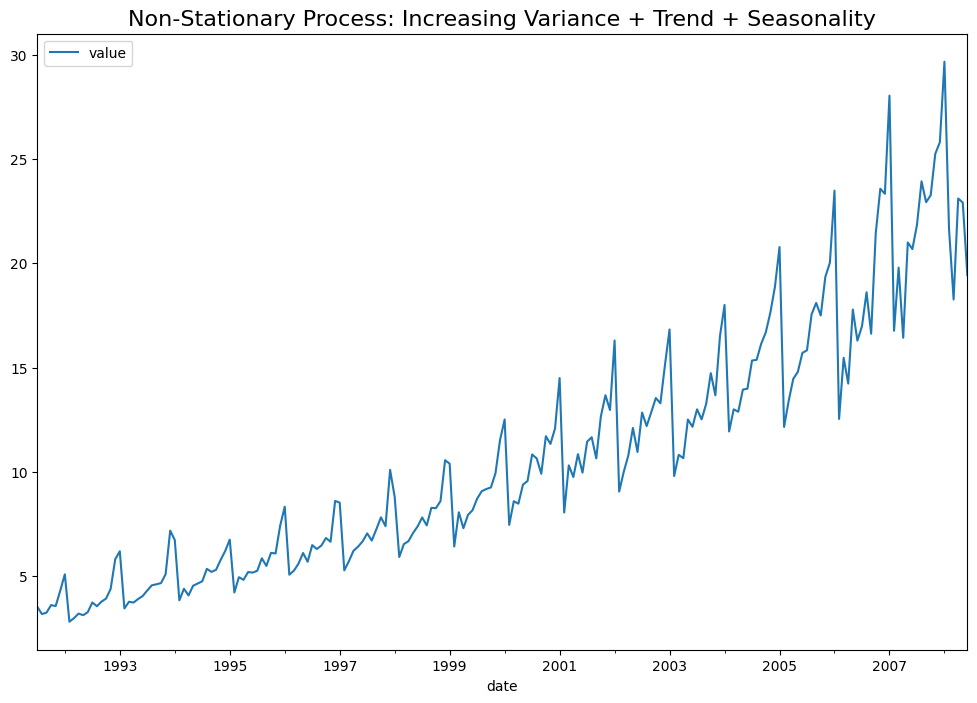

In [2]:
df.plot(figsize=[12, 8])
plt.title('Non-Stationary Process: Increasing Variance + Trend + Seasonality', fontsize=16)
plt.show()

In [3]:
from statsmodels.tsa.stattools import adfuller

## ADF
def ADF(data):

    result = adfuller(data, autolag="AIC")

    print("---- Adfuller ----")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
ADF(df) # 정상성을 띄지 않는다. 귀무가설을 채택.

---- Adfuller ----
ADF Statistic: 3.145186
p-value: 1.0000000000
Lag: 15
observation: 188
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


In [6]:
# 차분하기 전 로그를 씌워 분산성을 줄인다.
# 로그변환 (분산을 일정하게 하기 위해)
import numpy as np

df_vsf = np.log(df)
df_vsf.head()

,value
date,
1991-07-01,1.260332
1991-08-01,1.157161
1991-09-01,1.179338
1991-10-01,1.283986
1991-11-01,1.271408


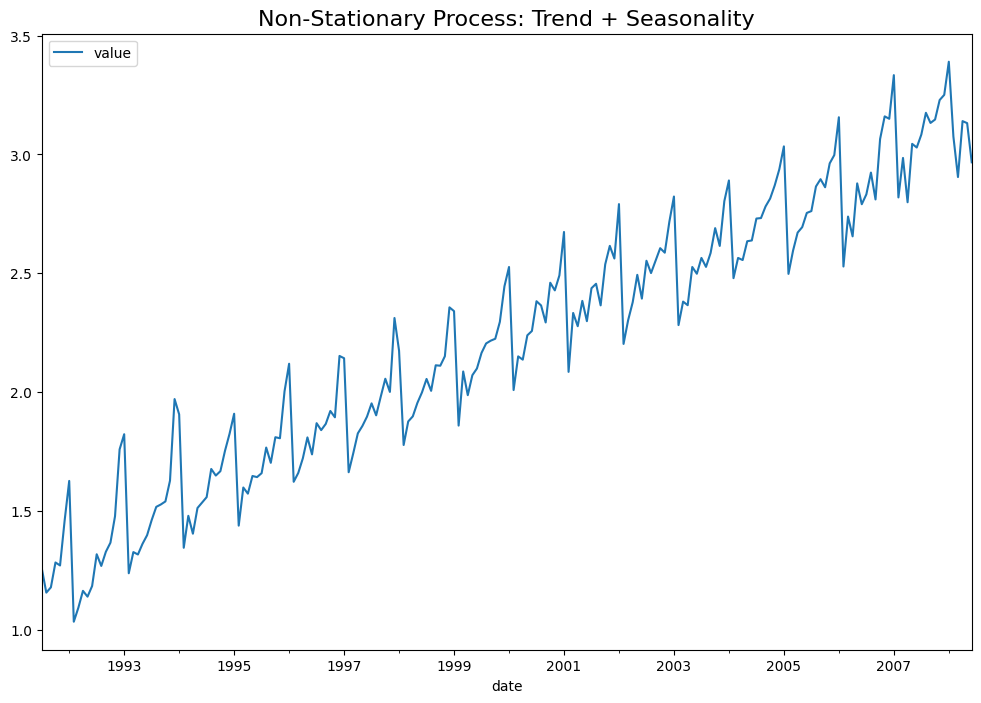

In [8]:
df_vsf.plot(figsize=[12, 8])
plt.title('Non-Stationary Process: Trend + Seasonality', fontsize=16)
plt.show()

In [12]:
# 차분을 통한 추세 제거
df_vsf.diff(1).isnull().sum()
# df_vsf_diff1 = df_vsf.diff(1).iloc[1:, :]
df_vsf_diff1 = df_vsf.diff(1).dropna()

In [13]:
df_vsf_diff1

,value
date,
1991-08-01,-0.103170
1991-09-01,0.022177
1991-10-01,0.104647
1991-11-01,-0.012578
1991-12-01,0.188688
...,...
2008-02-01,-0.314777
2008-03-01,-0.170220
2008-04-01,0.235181


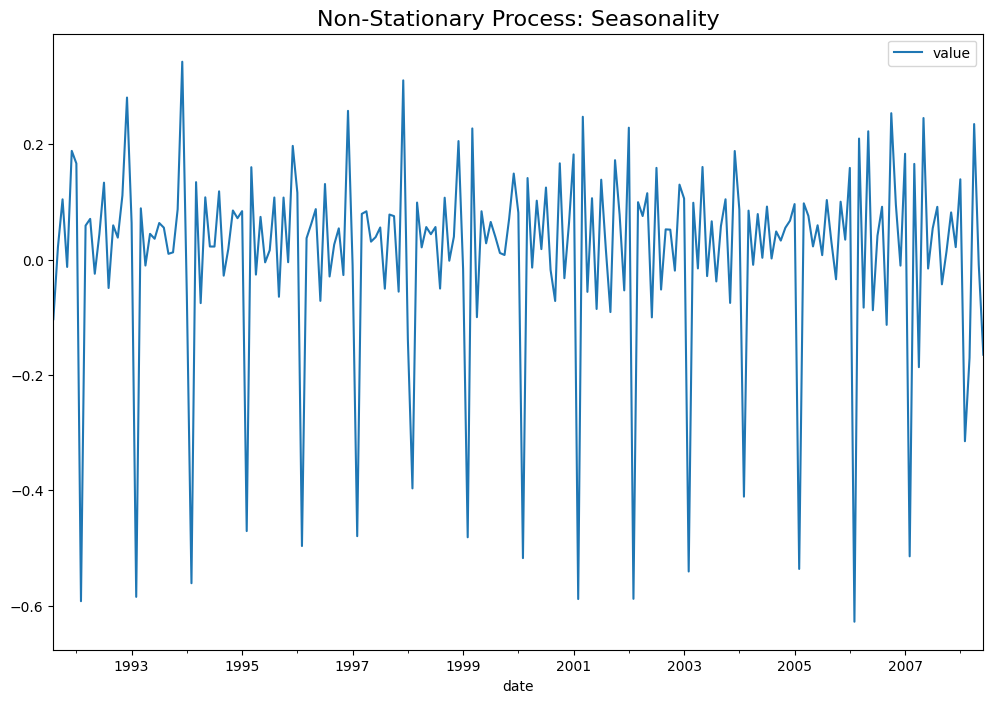

In [14]:
df_vsf_diff1.plot(figsize=[12, 8])
plt.title('Non-Stationary Process: Seasonality', fontsize=16)
plt.show()

In [15]:
ADF(df_vsf_diff1) # p-value가 0.05보다 작으므로 정상성 제거 확인

---- Adfuller ----
ADF Statistic: -4.519432
p-value: 0.0001813384
Lag: 13
observation: 189
Critical Values:
	1%: -3.465
	5%: -2.877
	10%: -2.575


In [17]:
# 차분을 통한 계절성 제거(계절성 timelag:12 로 제거)
df_vsf_diff1.diff(12).isnull().sum()

value    12
dtype: int64

In [19]:
df_vsf_diff1.diff12 = df_vsf_diff1.diff(12).dropna()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_10632\876024613.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_vsf_diff1.diff12 = df_vsf_diff1.diff(12).dropna()


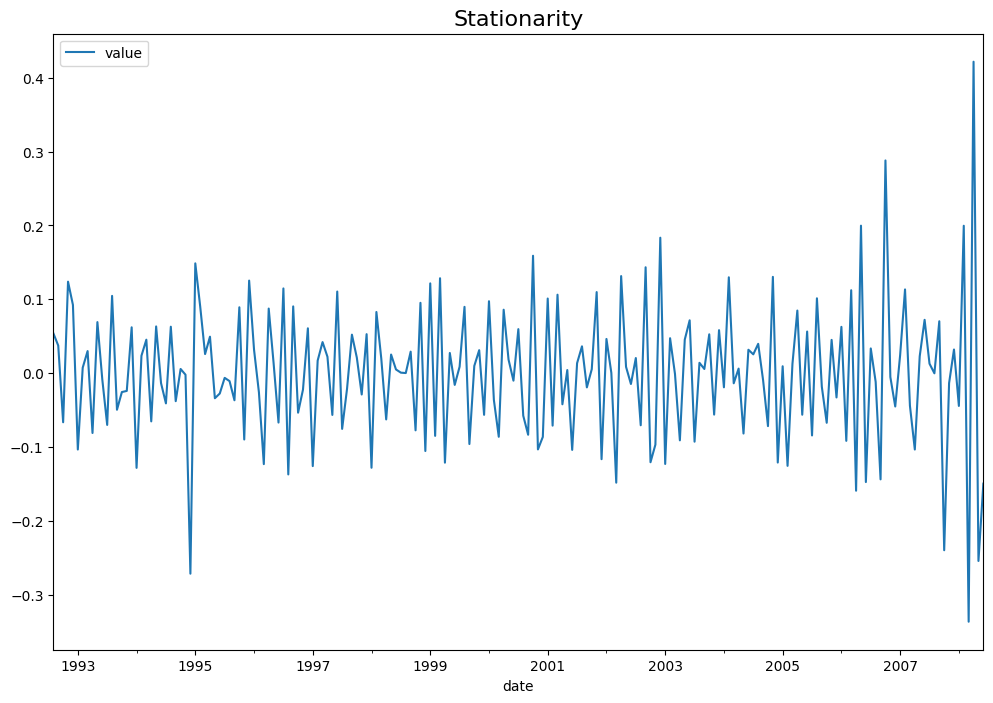

In [23]:
df_vsf_diff1.diff12.plot(figsize=[12, 8])
plt.title('Stationarity', fontsize=16)
plt.show()

In [22]:
ADF(df_vsf_diff1.diff12)

---- Adfuller ----
ADF Statistic: -4.785546
p-value: 0.0000579565
Lag: 13
observation: 177
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [24]:
import FinanceDataReader as fdr
import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

df = fdr.DataReader('GOOG' , start='2012-10-31' ,end='2022-10-31')
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-26,96.760002,98.540001,94.570000,94.820000,94.820000,71504300
2022-10-27,94.309998,95.169998,91.900002,92.599998,92.599998,54036500
2022-10-28,92.529999,96.860001,92.322998,96.580002,96.580002,35696900


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2012-10-31 to 2022-10-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2517 non-null   float64
 1   High       2517 non-null   float64
 2   Low        2517 non-null   float64
 3   Close      2517 non-null   float64
 4   Adj Close  2517 non-null   float64
 5   Volume     2517 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [26]:
df['Adj Close'][df['Volume'] ==0]

Series([], Name: Adj Close, dtype: float64)

#### 시계열 데이터, 이동평균, 이동표준편차 시각화

In [27]:
def plot_rolling(data , interval):
    rolmean = data.rolling(interval).mean()
    rolstd = data.rolling(interval).std()

    plt.figure(figsize=(10, 6))
    plt.xlabel('Date')
    plt.plot(data , color='blue', label='Original')
    plt.plot(rolmean , color='red', label=f'Rolling mean {interval}')
    plt.plot(rolstd , color='black', label=f'Rolling std {interval}')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Std')
    plt.show()

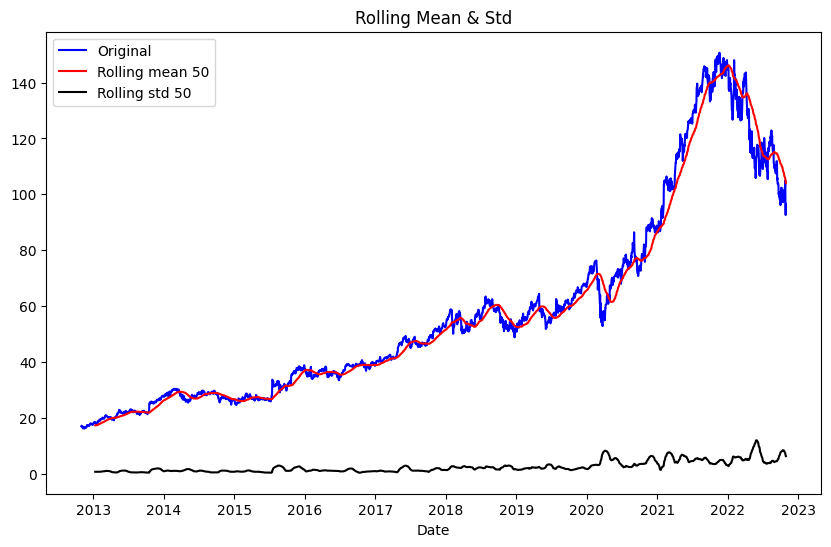

In [29]:
plot_rolling(df['Adj Close'], 50)

#### 정상성 데이터 확인 - ADF테스트

In [34]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Adj Close'])

In [35]:
result

(-0.772851369042787,
 0.8269670022786417,
 24,
 2492,
 {'1%': -3.432976825339513,
  '5%': -2.862700515844509,
  '10%': -2.5673877878037974},
 8123.380743513813)

In [36]:
## ADF
def ADF(data):

    result = adfuller(data, autolag="AIC")

    print("---- Adfuller ----")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [40]:
ADF(df['Adj Close'])

---- Adfuller ----
ADF Statistic: -0.772851
p-value: 0.8269670023
Lag: 24
observation: 2492
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


#### 차분한 결과의 ADF 테스트

In [38]:
df_diff1 = df['Adj Close'].diff().dropna()

<Axes: xlabel='Date'>

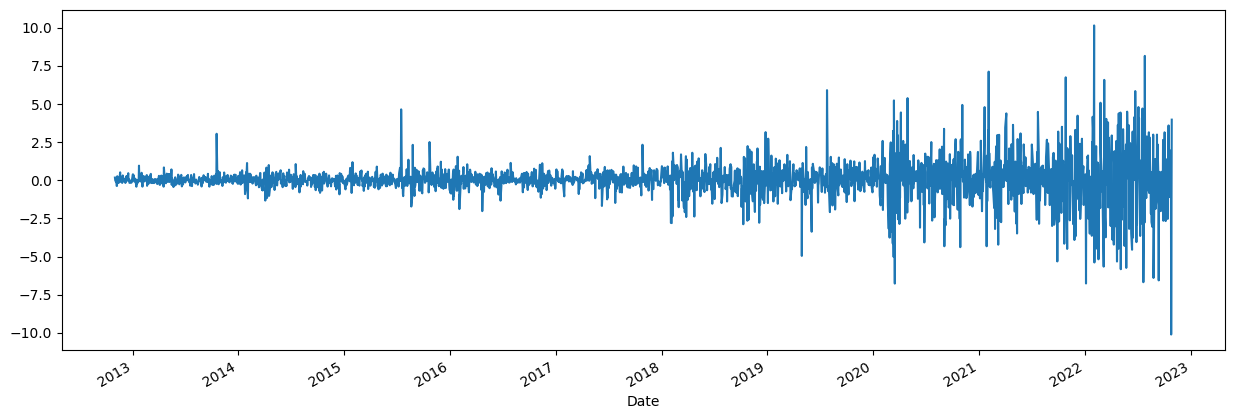

In [39]:
df_diff1.plot(figsize=(15,5))

In [42]:
ADF(df_diff1)

---- Adfuller ----
ADF Statistic: -10.592716
p-value: 0.0000000000
Lag: 23
observation: 2492
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


#### acf , pacf 를 통한  AR ,MA 확인

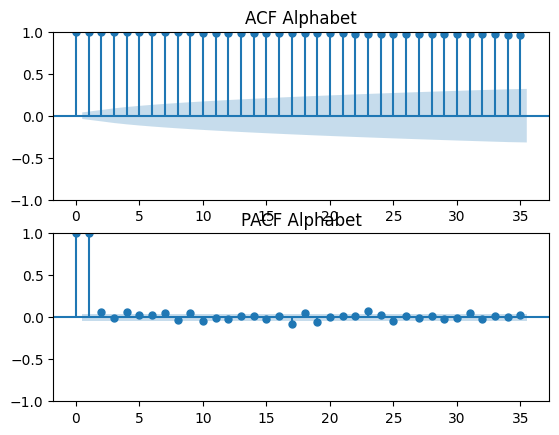

In [44]:
import statsmodels.graphics.tsaplots as sgt 
import matplotlib.pyplot as plt

## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df['Adj Close'], ax=ax1)
ax1.set_title("ACF Alphabet")


sgt.plot_pacf(df['Adj Close'],method = ('ols'), ax=ax2)
ax2.set_title("PACF Alphabet")

plt.show()

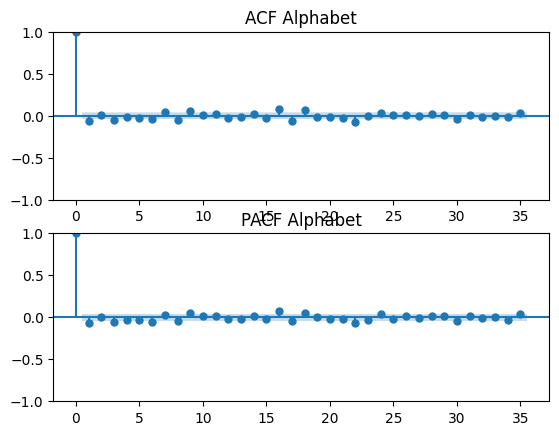

In [45]:
## Close
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

sgt.plot_acf(df_diff1,  ax=ax1)
ax1.set_title("ACF Alphabet")


sgt.plot_pacf(df_diff1, method = ('ols'), ax=ax2)
ax2.set_title("PACF Alphabet")

plt.show()

##### pmdarima.arima.auto_arima
* pmdarima.arima.auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)

#### pmdarima 을 활용

In [ ]:
pip install pmdarima

In [48]:
import pmdarima as pm
from pmdarima.arima import ndiffs

n_diffs = ndiffs(df['Adj Close'])
n_diffs

1

In [49]:
model = pm.auto_arima(y=df['Adj Close'],
            d=1,
            start_p = 0, max_p=3,
            start_q = 0, max_q=3,
            seasonal=False,
            trace = True
            )

# AIC값: 피쳐의 갯수

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8231.556, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8221.824, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8221.860, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8231.192, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=8223.799, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=8223.097, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8225.820, Time=0.35 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=8221.686, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=8223.648, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=8222.890, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=8221.739, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=8224.664, Time=0.37 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 2.417 seconds


In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -4108.843
Date:                Tue, 19 Mar 2024   AIC                           8221.686
Time:                        11:24:13   BIC                           8233.347
Sample:                             0   HQIC                          8225.918
                               - 2517                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0677      0.011     -6.070      0.000      -0.090      -0.046
sigma2         1.5346      0.018     87.291      0.000       1.500       1.569
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10915.24
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              20.60   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

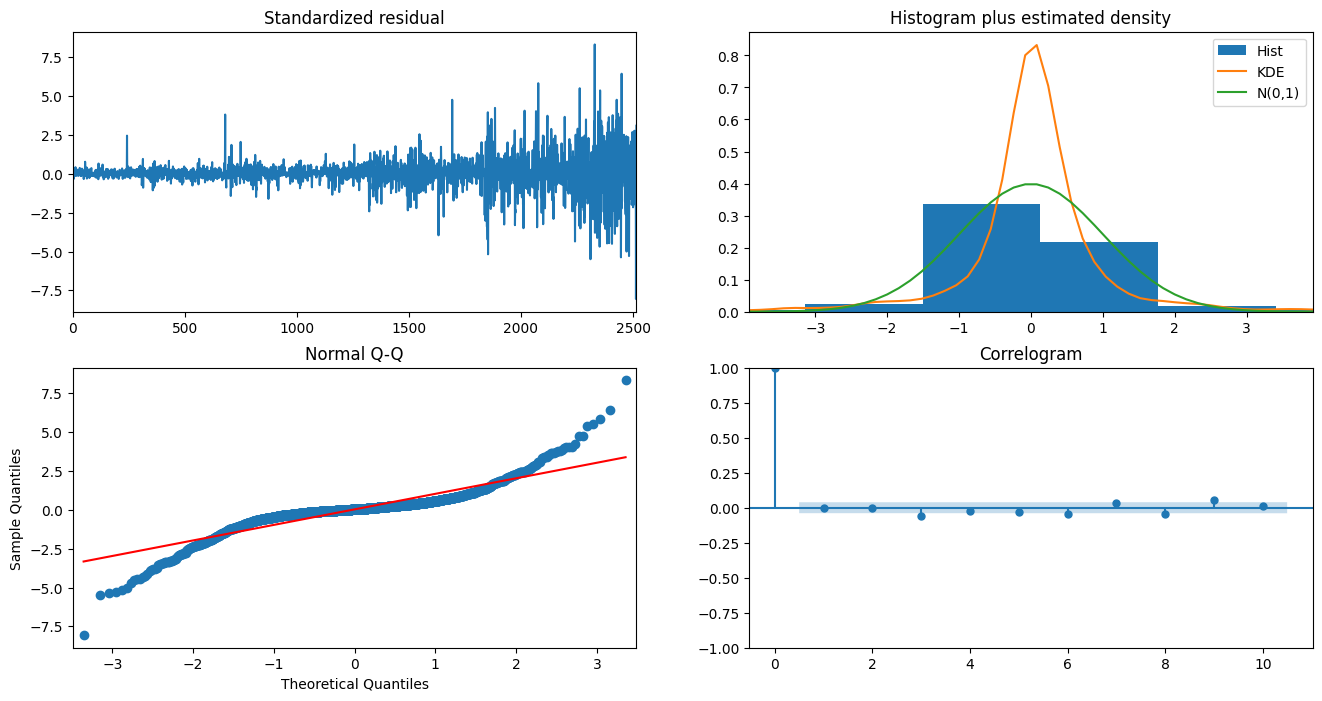

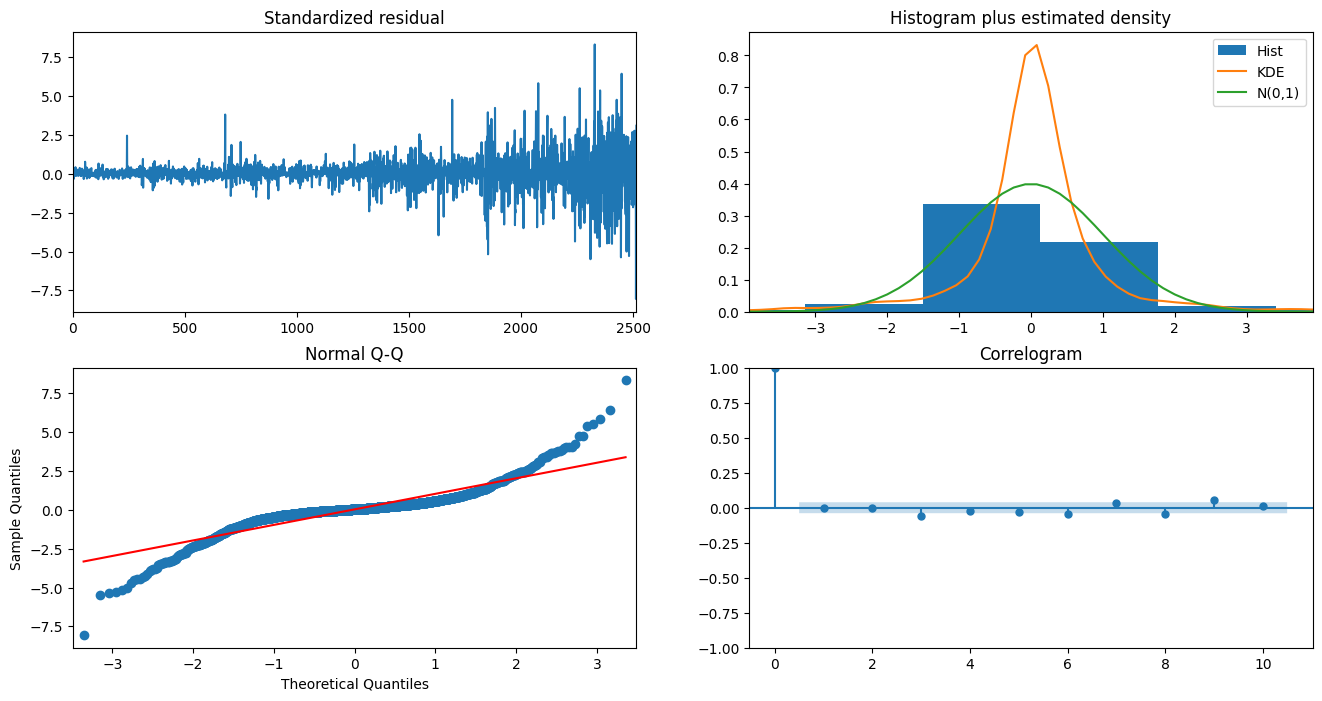

In [51]:
model.plot_diagnostics(figsize=(16 , 8))

#### ARIMA 모델 학습 과 테스트

In [52]:
# train , test set  분리
train_data , test_data = df['Adj Close'][:int(len(df['Adj Close'])*0.9)] ,df['Adj Close'][int(len(df['Adj Close'])*0.9):]

In [53]:
# train_data 학습

model = pm.auto_arima(y=train_data,
            d=1,
            start_p = 0, max_p=3,
            start_q = 0, max_q=3,
            seasonal=False,
            trace = True
            )
model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6127.619, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6119.112, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6119.471, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6134.024, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6120.306, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6118.765, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6120.764, Time=0.65 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6120.763, Time=0.77 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6120.804, Time=0.24 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6120.503, Time=1.59 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6126.014, Time=0.16 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.612 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2265
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3055.382
Date:                Tue, 19 Mar 2024   AIC                           6118.765
Time:                        13:12:49   BIC                           6141.664
Sample:                             0   HQIC                          6127.120
                               - 2265                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0851      0.028      3.000      0.003       0.030       0.141
ar.L1         -0.4906      0.106     -4.650      0.000      -0.697      -0.284
ma.L1          0.4247      0.108      3.915      0.000       0.212       0.637
sigma2         0.8704      0.011     82.185      0.000       0.850       0.891
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9707.41
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              11.78   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [54]:
pred = model.predict(len(test_data))

C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\SAMSUNG\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [55]:
pred

2265    146.397378
2266    146.350840
2267    146.458810
2268    146.490975
2269    146.560331
           ...    
2512    160.435275
2513    160.492390
2514    160.549505
2515    160.606620
2516    160.663735
Length: 252, dtype: float64

In [56]:
pred_ = pd.Series(list(pred) , index=test_data.index)

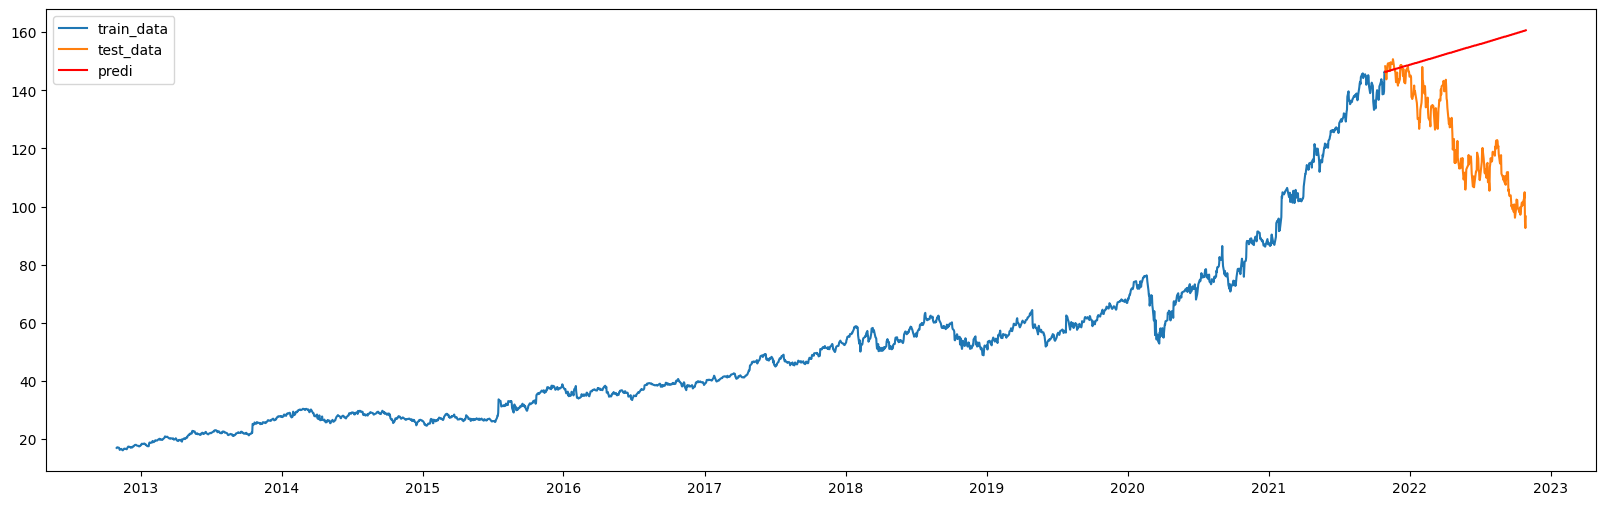

In [57]:
# train_data , test_data , pred plot
plt.figure(figsize=(20 ,6))
plt.plot(train_data , label='train_data')
plt.plot(test_data , label='test_data')
plt.plot(pred_ , c='red', label='predi')
plt.legend(loc='best')
plt.show()

In [58]:
#forecast 함수
def forecast_n_step(model , n=1):
    fc , conf_int = model.predict(n_periods=n , return_conf_int=True)
    return (fc.tolist()[0:n] , np.asarray(conf_int).tolist()[0:n] )

def forecast(length , model , index , data=None):
    y_pred = []
    pred_upper = []
    pred_lower = []

    if data is not None:
        for new_ob in data:
            fc , conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(new_ob)
    else:
        for i in range(length):
            fc , conf = forecast_n_step(model)
            y_pred.append(fc[0])
            pred_upper.append(conf[0][1])
            pred_lower.append(conf[0][0])
            model.update(fc[0])
    return pd.Series(y_pred , index=index) , pred_upper , pred_lower

In [61]:
# 예측
fc , upper , lower = forecast(len(test_data) , model , index=test_data.index , data=test_data)

In [62]:
upper_series = pd.Series(upper , index=test_data.index)
lower_series = pd.Series(lower , index=test_data.index)

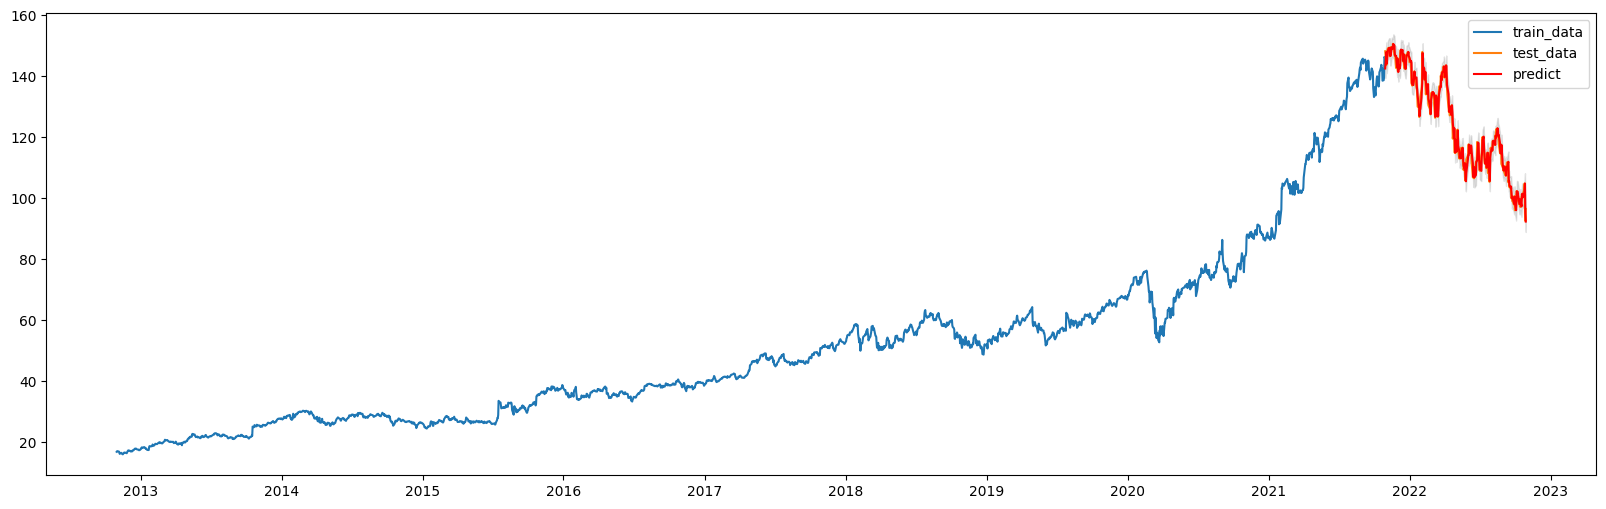

In [63]:
# train_data , test_data , pred plot
plt.figure(figsize=(20 ,6))
plt.plot(train_data , label='train_data')
plt.plot(test_data , label='test_data')
plt.plot(fc , c='red', label='predict')
plt.fill_between(lower_series.index ,lower_series , upper_series , color ='k' , alpha=0.10 )
plt.legend(loc='best')
plt.show()

#### 평가

In [64]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: ' ,'{:.2f}%'.format(mape*100))

MSE:  4.464974848964512e+128
MAE:  4.23406700913535e+63
RMSE:  2.1130487095579485e+64
MAPE:  11845.45%
